# Analysis of Movie Reviews dataset using Naive Bayes from scratch

## Importing the Libraries

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.utils import resample,shuffle
import string
string.punctuation # checking punctuations

df = pd.read_csv("/Users/rohitnair/Documents/MSDS/6120 NLP/movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative


In [2]:
count_pos = len(df[df['sentiment'] == 'positive'])
count_pos


12474

In [3]:
count_neg = len(df[df['sentiment'] == 'negative'])
count_neg

12225

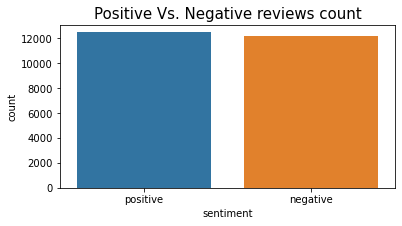

In [4]:
plt.figure(figsize = (6,3))
sns.countplot(x='sentiment' , data=df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()


## Upsampling the minority class


In [5]:
#upsampling 

df_majority = df[df['sentiment'] == 'positive']
df_minority = df[df['sentiment'] == 'negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([negative_upsample, df_majority])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)
df_upsampled

,review,sentiment
8431,"Nice, pleasant, and funny, but not earth-shatt...",positive
23921,I always wrote this series off as being a comp...,negative
15870,I pulled down a VHS box from my vast collectio...,positive
16276,An original uncensored print of this amazing f...,positive
2641,After a summer full of retreads and disappoint...,positive
...,...,...
19148,I am astounded that so many people find this f...,negative
20303,Bo Derek will not go down in history as a grea...,negative
21057,"""Catchfire"" or ""Backtrack"" as it is sometimes ...",negative
22462,"After sitting through this film, I have decide...",negative


In [6]:
df_upsampled[df_upsampled['sentiment'] == 'negative'].shape

(12474, 2)

In [7]:

## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([negative_data_points_train['review'], positive_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([negative_data_points_train['sentiment'], positive_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([negative_data_points_test['review'], positive_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([negative_data_points_test['sentiment'], positive_data_points_test['sentiment']])

y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

In [8]:
y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

## Pre-process the reviews

The code in the cell below is performing text preprocessing on a given text. The preprocessing steps being applied include:

1. Removing links
2. Removing punctuations
3. Removing stopwords
4. Lowercasing the text
5. Stemming the text.


Stemming is the process of reducing words to their base or root form. This helps in grouping similar words together and treating them as the same word. The purpose of lowercasing the text is to ensure that words like 'Admire' and 'admire' are not considered as different words. All the punctuation marks and links are also removed to clean the text and make it ready for further processing.



In [9]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
def removeStopwords(text):
    return " ".join([word for word in re.split('\W+', text) if word not in stopword])

In [10]:
ps = nltk.PorterStemmer()
def performStemming(text):
     return" ".join([ps.stem(word) for word in re.split('\W+', text)])

In [11]:
def clean_review(review):
    '''
    Parameter: review: a string containing a review.
    Output: review_cleaned: a processed review. 

    '''
    

    review_cleaned = re.sub('http\S+','',review)
    review_cleaned = re.sub('www\S+','',review)

    review_cleaned = "".join([char for char in review_cleaned if char not in string.punctuation])
    review_cleaned = removeStopwords(review_cleaned.lower())
    
    review_cleaned = performStemming(review_cleaned)
    return review_cleaned

## find_occurrence function
This function counts the number of times a specified word appears in all documents with a given label and returns the result.

In [1]:
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    n = frequency[(word,label)]
  
    return n

# Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

o is assigned to Positive labels and 1 to negative labels

In [13]:
output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [14]:
y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [15]:
X_train.iloc[0]

'I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hairy lightho

In [16]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

alway wrote seri complet stinkfest jim belushi involv heavili one day tragic happenst occur white sox game end realiz remot way side room somehow could gotten walk across room get remot even tv turn channel get walk across countri watch tv anoth state nut said decid hang tight couch take whatev fate store fate store episod show episod rememb littl except made broad gener sweep blanket judgment base zero object experienti evid noth whatsoev back opinion complet right show total crudpi belushi comed deliveri hairi lighthous foghorn women physic attract stepfordi elicit real feel viewer absolut reason stop run local tv station gasolin flamethrow send everi copi mutt howl back hell br br except br br except wonder comic sti ling larri joe campbel america greatest comic charact actor guy play belushi brotherinlaw andi gold good realli well asid funni job make belushi look good that like tri make butt wart look good campbel pull style someon invent nobel prize comic buffooneri win everi year

## Implementing review counter function

In this function, we count the occurrence of words and get the probabilities for the words based on the training data.

We calculate the probabilites of the word occuring in both positive reviews and negative reviews

In [17]:
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
            if output_occurrence.get((word , label)) == None:
                output_occurrence[(word , label)] = 1
            else:
                output_occurrence[(word , label)] += 1
                
   
    return output_occurrence
   


## Testing function with sample reviews



In [18]:

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bore', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movi', 0): 2,
 ('fantast', 0): 1,
 ('watch', 1): 1,
 ('complet', 1): 1,
 ('wast', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoy', 0): 1,
 ('fullest', 0): 1}

In [19]:
freqs = review_counter({}, X_train, y_train)

In [20]:
len(freqs)

98917

In [21]:
freqs

{('alway', 1): 920,
 ('wrote', 1): 282,
 ('seri', 1): 894,
 ('complet', 1): 1456,
 ('stinkfest', 1): 1,
 ('jim', 1): 150,
 ('belushi', 1): 17,
 ('involv', 1): 772,
 ('heavili', 1): 71,
 ('one', 1): 10446,
 ('day', 1): 1260,
 ('tragic', 1): 84,
 ('happenst', 1): 1,
 ('occur', 1): 147,
 ('white', 1): 460,
 ('sox', 1): 4,
 ('game', 1): 597,
 ('end', 1): 3608,
 ('realiz', 1): 463,
 ('remot', 1): 204,
 ('way', 1): 3185,
 ('side', 1): 482,
 ('room', 1): 379,
 ('somehow', 1): 347,
 ('could', 1): 3615,
 ('gotten', 1): 123,
 ('walk', 1): 636,
 ('across', 1): 398,
 ('get', 1): 6038,
 ('even', 1): 6272,
 ('tv', 1): 1031,
 ('turn', 1): 1526,
 ('channel', 1): 263,
 ('countri', 1): 275,
 ('watch', 1): 5836,
 ('anoth', 1): 1682,
 ('state', 1): 379,
 ('nut', 1): 50,
 ('said', 1): 996,
 ('decid', 1): 789,
 ('hang', 1): 194,
 ('tight', 1): 57,
 ('couch', 1): 29,
 ('take', 1): 2477,
 ('whatev', 1): 342,
 ('fate', 1): 95,
 ('store', 1): 245,
 ('episod', 1): 707,
 ('show', 1): 3278,
 ('rememb', 1): 651,
 (

## Training the Naive Bayes Model

This code is implementing the training phase of the Naive Bayes algorithm. 

It focuses on calculating the log likelihood and log prior values, which are crucial for the testing phase in subsequent cells. 

The function returns the logprior and loglikelihood values generated by the model.



In [22]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        x: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = []
    vocab = list(freqs.keys())
    val = list(freqs.values())
    vocab2 = set(list(a[0] for a in freqs.keys()))
    V = len(vocab2)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for a,b in freqs.keys():
        if b == 0 : 
            num_pos += freqs[(a,b)]
        else :
            num_neg += freqs[(a,b)]
        

    # Calculate num_doc, the number of documents
    num_doc = len(train_x)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = len(train_y[train_y==0])

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = len(train_y[train_y==1])

    # Calculate logprior
    logprior = np.log(pos_num_docs/num_doc) - np.log(neg_num_docs/num_doc)

    # For each word in the vocabulary...
    for word in vocab2:
        # get the positive and negative frequency of the word
        if freqs.get((word , 0)) != None:
                freq_pos = freqs[(word , 0)]
        else: 
            freq_pos = 0
        if freqs.get((word , 1)) != None:
                freq_neg = freqs[(word , 1)]
        else:
            freq_neg = 0

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(V+num_pos)
        p_w_neg = (freq_neg+1)/(V+num_neg)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
        
        ##NOTE - here, loglikelihood value is positive if the word is positive(sentiment). And loglikelihood is negative if the word id negative(sentiment).
        ## The functions below have been written w.r.t this sign convention.
        ## if we want the loglikelihood to be negative for a positive(sentiment) word, loglikelihood[word] = np.log(p_w_neg/p_w_pos)
        
        


    return logprior, loglikelihood

In [23]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
75347


## Implementing Naive Bayes Predict Function

The predict function outputs a 1 (negative) if the sum of the log likelihood values is greater than 0 and outputs a 0 (positive) if the sum of the log likelihood is less than or equal to 0.


In [24]:
def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = total_prob + logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
    
    if total_prob < 0:
        p = 1
    else:
        p = 0


    return p



###Testing predict function on sample review

In [25]:
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


## Naive Bayes Test function



In [27]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    
    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review ,logprior, loglikelihood ) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        print(y_hat_i)
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.average(np.absolute(y_hats - test_y))

    accuracy = 1-error


    return accuracy

In [28]:

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Analysis

The code in this question performs the following tasks:

Data split: It splits the data into training and test sets using random selection. The user can change the training and test set by adjusting the seed parameter in the function.

Model parameter calculation: Using the training set, the code calculates the parameters of the model.

Confusion matrix calculation: The code prints the confusion matrix for both the training and test sets.

False Positive and False Negative analysis: The code examines false positive and false negative cases and provides an explanation for why they were misclassified.

The overall goal of this code is to evaluate the performance of the model on the test data and to understand the mistakes made by the model.



In [30]:
# TASK 4 CELL

def naive_bayes_predict1(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    word_l = clean_review(review).split()

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob = total_prob + logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
    
    


    return total_prob



In [31]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
from sklearn.metrics import confusion_matrix

def test_naive_bayes_conf(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    y_hats = []
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict1(review ,logprior, loglikelihood ) > 0:
            # the predicted class is 1
            y_hat_i = 0
        else:
            # otherwise the predicted class is 0
            y_hat_i = 1
        
        # append the predicted class to the list y_hats
        #print(y_hat_i)
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.average(np.absolute(y_hats - test_y))
    accuracy = 1-error
    print("accuracy = " , accuracy)
    data_conf = {'y_actual':  test_y  , 'y_predicted': y_hats}
    df_conf = pd.DataFrame(data_conf)
    confusion_matrix1 = pd.crosstab(df_conf['y_actual'], df_conf['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
    print("confusion_matrix = " )
    print(confusion_matrix1)
    
    print()
    return confusion_matrix



In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def split_data(seed):
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_upsampled['review'], df_upsampled['sentiment'] , random_state=seed)
    output_map = {'positive': 0, 'negative': 1}
    y_train_new = y_train_new.map(output_map)
    y_test_new = y_test_new.map(output_map)
    freqs = review_counter({}, X_train_new, y_train_new)
    logprior_new, loglikelihood_new = train_naive_bayes(freqs, X_train_new, y_train_new )
    print("log prior = " , str(round(logprior_new, 2)))
    print("loglikelihood = ", len(loglikelihood_new))
    conf = test_naive_bayes_conf(X_test_new,y_test_new,logprior_new ,loglikelihood_new)
    #print(conf)


In [33]:
split_data(25)

log prior =  -0.0
loglikelihood =  72919
accuracy =  0.8731762065095399
confusion_matrix = 
Predicted     0     1
Actual               
0          2607   519
1           272  2839



Precision = TruePositives / (TruePositives + FalsePositives)  = 2607/(2607+ 272) = 0.905

Recall = TruePositives / (TruePositives + FalseNegatives) = 2607/(2607+519) = 0.834



4. In the above data, misclassification has occured because there may be words in the review that were more used in the opposite sentiment reviews in the test data. Because of this, the likelihood of the term in the opposite sentiment was higher. 